## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 21249929
* Student name(s): Caolan McDonagh

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [16]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [18]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [19]:
img_array = np.array(images)

In [20]:
img_array.shape

(1238, 268, 182, 3)

In [21]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [22]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [23]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [24]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [25]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [26]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [27]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [260]:
n_movies = img_array.shape[0]
embedding_size = 76032 # Acquired via output.shape of initModel.
X = tf.zeros((n_movies, embedding_size))
### YOUR CODE HERE

#Imports relevant to part 1
from keras.applications.efficientnet import EfficientNetB2
from keras.models import Model

#include_top = false to disconnect final layer.
initModel = EfficientNetB2(include_top = False, weights = 'imagenet', input_shape=(268,182,3))
#Create our flat layer for embeddings
flatLayer = layers.Flatten()(initModel.output)

trainedModel = Model(inputs=initModel.input,outputs=flatLayer)

trainedModel.summary()

#Get the embeddings of the img_array
embeddingVectors = trainedModel.predict(img_array)

X = np.vstack(embeddingVectors)

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 268, 182, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 268, 182, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_5 (Normalization  (None, 268, 182, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                           

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [261]:

from sklearn.metrics.pairwise import cosine_similarity
from keras.utils import img_to_array

def k_nearest(img, k):
    ### YOUR CODE HERE

    cosineSimilarities = [] #Storage for similarities 

    selectedImage = trainedModel.predict(img) #Get embeddings for selected image
    
    #Compare each image in the dataset to the selected image (embeddings)
    for i in X:
        cosineSim = cosine_similarity(selectedImage, i.reshape(1, -1))
        cosineSimilarities.append(cosineSim)


    cosineWithID = list(zip(IDs, cosineSimilarities)) #add IDs for pulling posters later
    sortedCosine = sorted(cosineWithID, key= lambda i:i[1]) #Sorting
    sortedCosine.pop(-1) #Remove the 1:1 match, e.g the searched image.
    
    kNearest = sortedCosine[-k:] #Get last k values (e.g most similar)
    kNearestID = [id[0] for id in kNearest] #Extract just the IDs for return

    return kNearestID

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


1/1 [==============================] - 0s 112ms/step
ID: 1000771
Year: 2008.0
Genre: Drama|History
K Nearest posters:


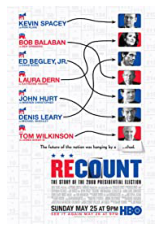

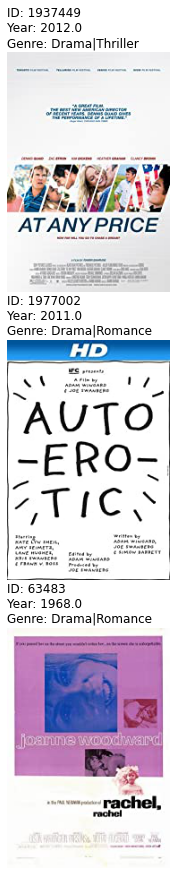

In [262]:
### YOUR CODE HERE
Q_idx = 1000771 # YOUR VALUE HERE - DO NOT USE MY VALUE

#Year and genre of selected poster
Year = df4.loc[df4.index == Q_idx, 'Year'].item()
Genre = df4.loc[df4.index == Q_idx, 'Genre'].item()

k = 3 #Count of nearest neighbours to find.

#Preprocess image for k_nearest
image = imread(Q_idx) #Read selected poster
image = img_to_array(image) #set to array for use in k_nearest (embedding)
image = np.expand_dims(image, axis=0) #Correct size

nearestPosters = k_nearest(image, k) #where 3 = k neighbors.

print("ID: " + str(Q_idx) +  "\nYear: " + str(Year) +  "\nGenre: " + str(Genre))

#Display selected poster
imshow(imread(Q_idx))


#For displaying k images
posterCount = len(nearestPosters)

#Subplot explanation from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axes = plt.subplots(k) #Create figure + axis based on number of neighbours, in this case 3.

fig.set_figheight(15) #Make posters larger
fig.set_figwidth(15)

print("K Nearest posters:")

for i, poster in enumerate(nearestPosters):
    axes[i].imshow(imread(poster)) #Read ID + display poster
    
    #Get posters information for k nearest investigation
    kYear = df4.loc[df4.index == poster, 'Year'].item()
    kGenre = df4.loc[df4.index == poster, 'Genre'].item()
    #Display poster information (Print won't work here)
    axes[i].set_title("ID: " + str(poster) +  "\nYear: " + str(kYear) +  "\nGenre: " + str(kGenre), loc="left")

    axes[i].axis('off') #Remove irrelevant axis from subplots



## Part 3 comments

Note: posters are in descending order, where first of the three posters is 3rd in similarity, and last poster is most similar.

I think the cosine similarity worked well here. With regards to visuals, the images hold similar colour ways, such as being majority white, with hints of Blues, reds and blacks. Although the last image strays a bit from this, where purple is one of the dominant colours. The original poster does have blue+red (which mixes to purple), but that is a bit of a stretch.


Years are relatively close, except for the 3rd poster, but the genres are all at least dramas. As for romance/thriller/history, these all differ. The fact they are all dramas is a good sign.

Overall I agree with the rankings here, given similar visuals, genre and relatively similar years for 2/3.

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [263]:
### YOUR CODE HERE
from sklearn.model_selection import train_test_split
from keras import layers, models
from keras.layers import Dense,Input

years = df4[["Year"]] #Get just years

#Creating test/train split and normalsing pixel values.
X_train, X_test, y_train, y_test = train_test_split(img_array,years,test_size=0.3)
X_train = X_train / 255.0
X_test = X_test / 255.0

#Create an input tensor//input shape for regression that matches our img_array.
inputShape = Input(shape=(268,182,3))
part1Model = trainedModel(inputShape) #Model from part 1
print(part1Model.shape)

#Using the output of our initial model as the input to regression
#Using 4 dense layers, with the last being one neuron to produce one value (e.g the year).
#relu activation function used for vanishing gradients.
regressor = layers.Dense(512, activation='relu')(part1Model)
regressor = layers.Dense(256, activation='relu')(regressor)
regressor = layers.Dense(128, activation='relu')(regressor)
regressor = layers.Dense(1)(regressor)

#Create our full model with the same input tensor and outputs from the regression head.
regressionModel = Model(inputs=inputShape, outputs=regressor)

#using Adam optimizer as it is a common DNN optimizer and highly recognised. 
#MSLE to avoid over/under estimates and minimizing error.
#MAE is a common standard for regression and can handle large variations.
regressionModel.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mae'])

regressionModel.summary()




(None, 76032)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 268, 182, 3)]     0         
                                                                 
 model_10 (Functional)       (None, 76032)             7768569   
                                                                 
 dense_20 (Dense)            (None, 512)               38928896  
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 46,861,818
Trainable params: 4

In [276]:
history = regressionModel.fit(X_train,y_train,epochs=12,batch_size=100,validation_split=0.03) #runtime: 20mins

regressionModel.save("RegressionModel") #Saving to prevent training over and over.


Epoch 1/12
9/9 [==============================] - 102s 11s/step - loss: 13.3163 - mae: 1410.6318 - val_loss: 10.1739 - val_mae: 1909.7960
Epoch 2/12
9/9 [==============================] - 94s 10s/step - loss: 0.3343 - mae: 1466.0692 - val_loss: 3.5740 - val_mae: 1690.7823
Epoch 3/12
9/9 [==============================] - 94s 10s/step - loss: 0.1292 - mae: 613.3856 - val_loss: 6.1770 - val_mae: 1826.0924
Epoch 4/12
9/9 [==============================] - 94s 10s/step - loss: 0.0350 - mae: 303.4424 - val_loss: 4.7557 - val_mae: 1767.0769
Epoch 5/12
9/9 [==============================] - 94s 10s/step - loss: 0.0092 - mae: 145.2354 - val_loss: 3.3429 - val_mae: 1672.0077
Epoch 6/12
9/9 [==============================] - 94s 10s/step - loss: 0.0061 - mae: 118.2343 - val_loss: 2.9599 - val_mae: 1635.3523
Epoch 7/12
9/9 [==============================] - 96s 11s/step - loss: 0.0036 - mae: 90.6178 - val_loss: 1.0927 - val_mae: 1249.7690
Epoch 8/12
9/9 [==============================] - 96s 11s/

INFO:tensorflow:Assets written to: RegressionModel\assets


INFO:tensorflow:Assets written to: RegressionModel\assets


In [265]:
yearPredictModel = keras.models.load_model("RegressionModel")

eval = yearPredictModel.evaluate(X_test,y_test)
print("Loss, MAE", eval)

12/12 [==============================] - 14s 1s/step - loss: 0.0056 - mae: 152.0591
Loss, MAE [0.005579752381891012, 152.05911254882812]


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


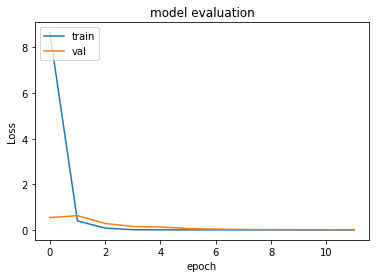

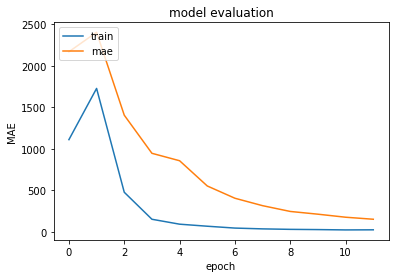

In [266]:
print(history.history.keys())

#Plot source: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

#Loss vs val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model evaluation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#MAE vs val_mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model evaluation')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'mae'], loc='upper left')
plt.show()

12/12 [==============================] - 14s 1s/step


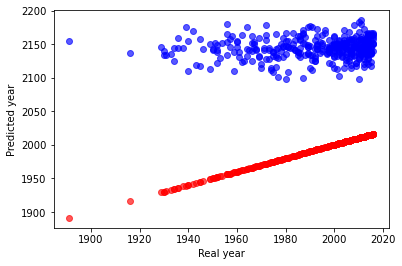

In [267]:
y_pred = yearPredictModel.predict(X_test) #you can pass a single poster here via imread(posterID), seen below.

plt.scatter(y_test, y_pred, c='b', alpha=0.65, label='predicted')
plt.scatter(y_test, y_test, c='r', alpha=0.65, label='actual')
plt.xlabel('Real year')
plt.ylabel('Predicted year')
plt.show()


## Part 4 comments

Looking at the MAE and LOSS plots, the model does look to be performing well, with very low values of loss and MAE: [0.0054201362654566765, 150.1516571044922]

In contrast to this though, our predictions are at least 100 years in the future, which isn't ideal. Looking at the scatter plot of predictions vs real years, it is more spread than the real movie years, showing the predictions vary quite a bit. I suppose this does make sense in a way, movie posters are often fairly unique and haven't really deviated much as time went on. Colour printing existed before the first movie on this list, so what the image looks like doesn't really indicate the era it came from. They are of course more stylized as seen below, but I believe it may be hard for regression to associate this stylized poster to a given year/era.

![alt text](images.png "Movie posters through the decades")
Source: https://www.quora.com/Has-anyone-noticed-that-in-the-1980s-the-movie-posters-are-hand-drawn-why-is-this

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [268]:
### YOUR CODE HERE
from sklearn.manifold import TSNE

years = []
genres = []

#Get years and genre for grouping colours within t-sne plots later.
for i, data in enumerate(IDs):
    tempYear = df4.loc[df4.index == data, 'Year'].item()
    years.append(tempYear)
    tempGenre = df4.loc[df4.index == data, 'Genre'].item()
    genres.append(tempGenre)

#Used for rounding years down to their respective decade, credit: https://stackoverflow.com/questions/13082698/rounding-down-integers-to-nearest-multiple
def roundDown(number, divisor):
    return number - (number % divisor)

decades = [roundDown(int(value),10) for value in years]

#emeddingsWithGenre = list(zip(genres, X)) 
#emeddingsWithYear = list(zip(years, X)) 

#t-sne work
tsneYear = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsneOutputYear = tsneYear.fit_transform(X)


c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


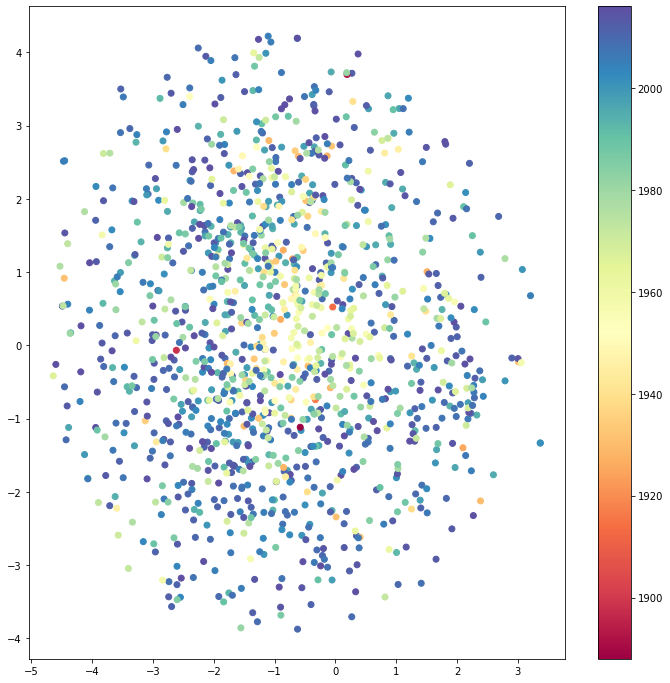

In [269]:
plt.figure(figsize=(12,12))
plt.scatter(tsneOutputYear[:, 0], tsneOutputYear[:, 1], c=years, cmap='Spectral')
plt.colorbar()
plt.show()

## Part 5 comments

I used t-sne (T-distributed stochastic neighbor embedding) which is a dimensionality reduction algorithm, which can let us pull underlying patterns from our data (see the image at the bottom of this markdown for a visual of the Fashion MNist dataset, as seen in assignment 1.)

With this we can potentially pull out seperations in our data to see how our embeddings correlate, and therefore let us understand if they are great or poor at future tasks involving said embeddings.

The plot above shows the t-sne, grouped by year. Each unique year is given a unique colour. We can see from the above plot, there is a vague pattern showing, with older movies congregating in the centre (mostly) and more recent movies (2000's and up) spreading to the further bounds of the plot. This could hint that the posters embeddings are potentially seperable based on the year they came out, this could be due to the old stylized format movie posters has in the early days, compared to modern posters that make more use of photographs of actors/actresses on their posters.


![Alt text](FashionMnist.jpg)



I also wanted to see if they were more seperable on decade, which you can see in the below plot.

In [270]:
tsneDecade = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsneOutputDecade = tsneDecade.fit_transform(X)

c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


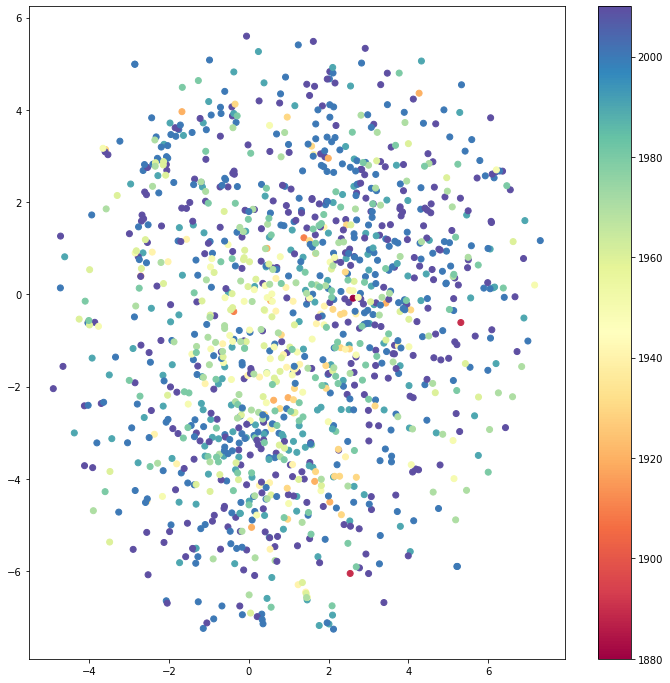

In [271]:
plt.figure(figsize=(12,12))
plt.scatter(tsneOutputDecade[:, 0], tsneOutputDecade[:, 1], c=decades, cmap='Spectral')
plt.colorbar()
plt.show()

## Part 5 comments

The above plot of t-sne, colour grouped by decade looks to reinforce the observations from the original t-sne bawsed on year, where older film posters look to group together (mostly) and as you get to the outer reaches of the plot, you see more and more newer films, which also happen to be more spread out. This could be due to more modern posters including more unique and creative design, wider varieties of colour and more unrealistic visuals on the poster (such as monsters or robots in sci-fi films), that weren't really present on many posters from before the 1960's.

In [272]:
tsneGenre = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=5000, n_iter_without_progress=1250)
tsneOutputGenre = tsneGenre.fit_transform(X)

c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


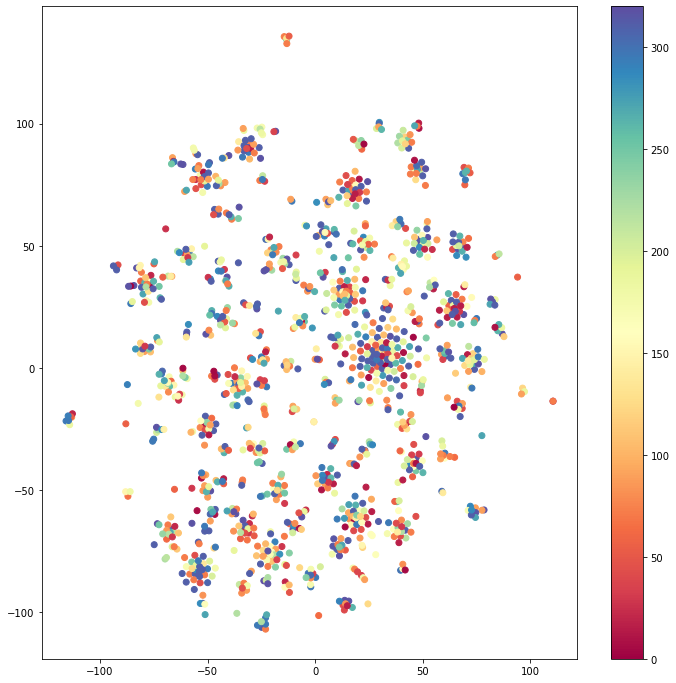

In [273]:
#Plot doesn't accept list of strings as valid colours, so convert to numbers:
genreNumbers = {genre: i for i, genre in enumerate(set(genres))}
genreColours = [genreNumbers[genre] for genre in genres]

plt.figure(figsize=(12,12))
plt.scatter(tsneOutputGenre[:, 0], tsneOutputGenre[:, 1], c=genreColours, cmap='Spectral')
plt.colorbar()
plt.show()

## Part 5 comments

Using multiple different hyperparameters for t-sne calculations (primarily perplexity, which is releated to the number of nearest neighbors), most gave seemingly random/scattered results. Lowering perplexity to 2 gave the above plot, which shows the there is no real link in embeddings between Genre and the posters. Each genre can have wildly varying posters and the embeddings would essentially be no good at differentiating them, as seen by the clusters above where multiple genres are grouped together, in contrast to the pattern in the previous plot.

In [274]:
#Testing another models embeddings on t-sne:

#The "v2" of the original model used.
from keras.applications import EfficientNetV2B2

newModel = EfficientNetV2B2(include_top = False, weights = 'imagenet', input_shape=(268,182,3))
newFlatLayer = layers.Flatten()(newModel.output) #GlobalAveragePooling2D

newTrainedModel = Model(inputs=newModel.input,outputs=newFlatLayer)

newTrainedModel.summary()

newEmbeddingVectors = newTrainedModel.predict(img_array)

newX = np.vstack(newEmbeddingVectors)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 268, 182, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 268, 182, 3)  0           ['input_13[0][0]']               
                                                                                                  
 normalization_6 (Normalization  (None, 268, 182, 3)  0          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                           

In [241]:
#Testing on decades

tsneDecadeV2 = TSNE(n_components=2, random_state=0, perplexity=3, n_iter=5000)
tsneOutputDecadeV2 = tsneDecadeV2.fit_transform(newX)

c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


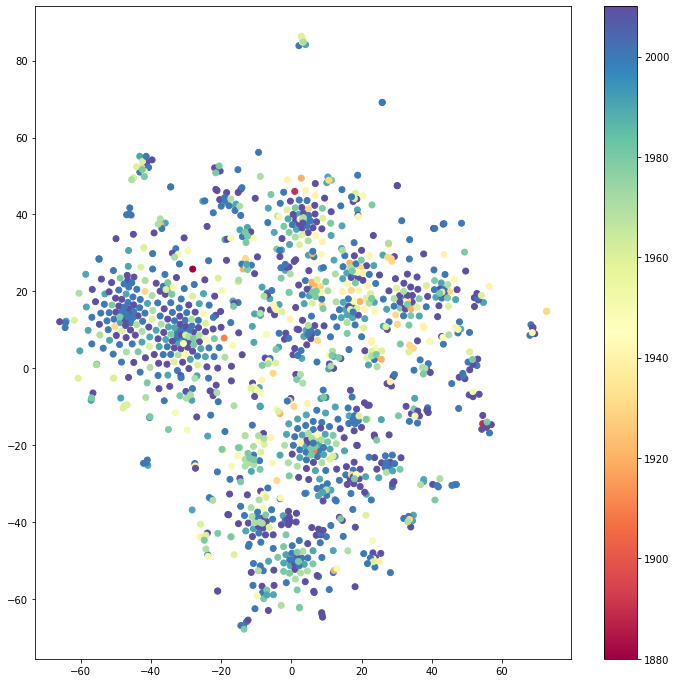

In [275]:
plt.figure(figsize=(12,12))
plt.scatter(tsneOutputDecadeV2[:, 0], tsneOutputDecadeV2[:, 1], c=decades, cmap='Spectral')
plt.colorbar()
plt.show()

## Part 5 comments

We can see similar behaviour with the same perplexity value, but if we change this. What originally looked random, now has a drastically different look, as seen in the above plot. Clusters have begin to form, where the largest clusters are from the relatively same era, e.g the large cluster in the central-left, is posters mostly from 1970s and up, with the most modern films concentrated at the centre. A lot of these posters hold photosgraphs of the characters in the centre of these posters, which could be a reason for this clustering.

In [247]:
tsneGenreV2 = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=5000, n_iter_without_progress=1250)
tsneOutputGenreV2 = tsneGenreV2.fit_transform(newX)

c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\CAOLA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


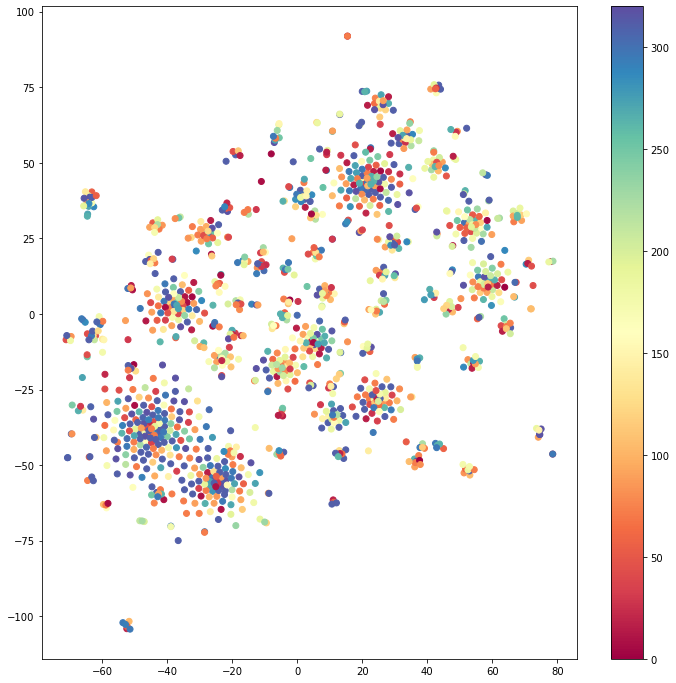

In [248]:
plt.figure(figsize=(12,12))
plt.scatter(tsneOutputGenreV2[:, 0], tsneOutputGenreV2[:, 1], c=genreColours, cmap='Spectral')
plt.colorbar()
plt.show()

## Part 5 comments

We can see a similar resutls using the new model on the genre t-sne, but the clusters are larger, with certain genres (colours) closer together. This does also reinforce the observation that genre and posters don't correlate well, with plenty of different colours mixed within these clusters.